# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Prepare paths of input images and target segmentation masks

In [12]:
import os
root_dir = '../data/vagus_dataset_2/'
input_dir = root_dir + "images/"
target_dir = root_dir + "annotations/"
img_size = (160, 160)
num_classes = 3
batch_size = 2

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 48
../data/vagus_dataset_2/images/Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0005.jpg | ../data/vagus_dataset_2/annotations/Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0005.jpg
../data/vagus_dataset_2/images/Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0007.jpg | ../data/vagus_dataset_2/annotations/Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0007.jpg
../data/vagus_dataset_2/images/Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0009.jpg | ../data/vagus_dataset_2/annotations/Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0009.jpg
../data/vagus_dataset_2/images/Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0015.jpg | ../data/vagus_dataset_2/annotations/Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0015.jpg
../data/vagus_dataset_2/images/Vago dx 21.02.19 DISTALE con elettrodo - vetrino 1 - fetta 0020.jpg | ../data/vagus_dataset_2/annotations/Vago dx 21.02.19 DIST

## What does one input image and corresponding segmentation mask look like?

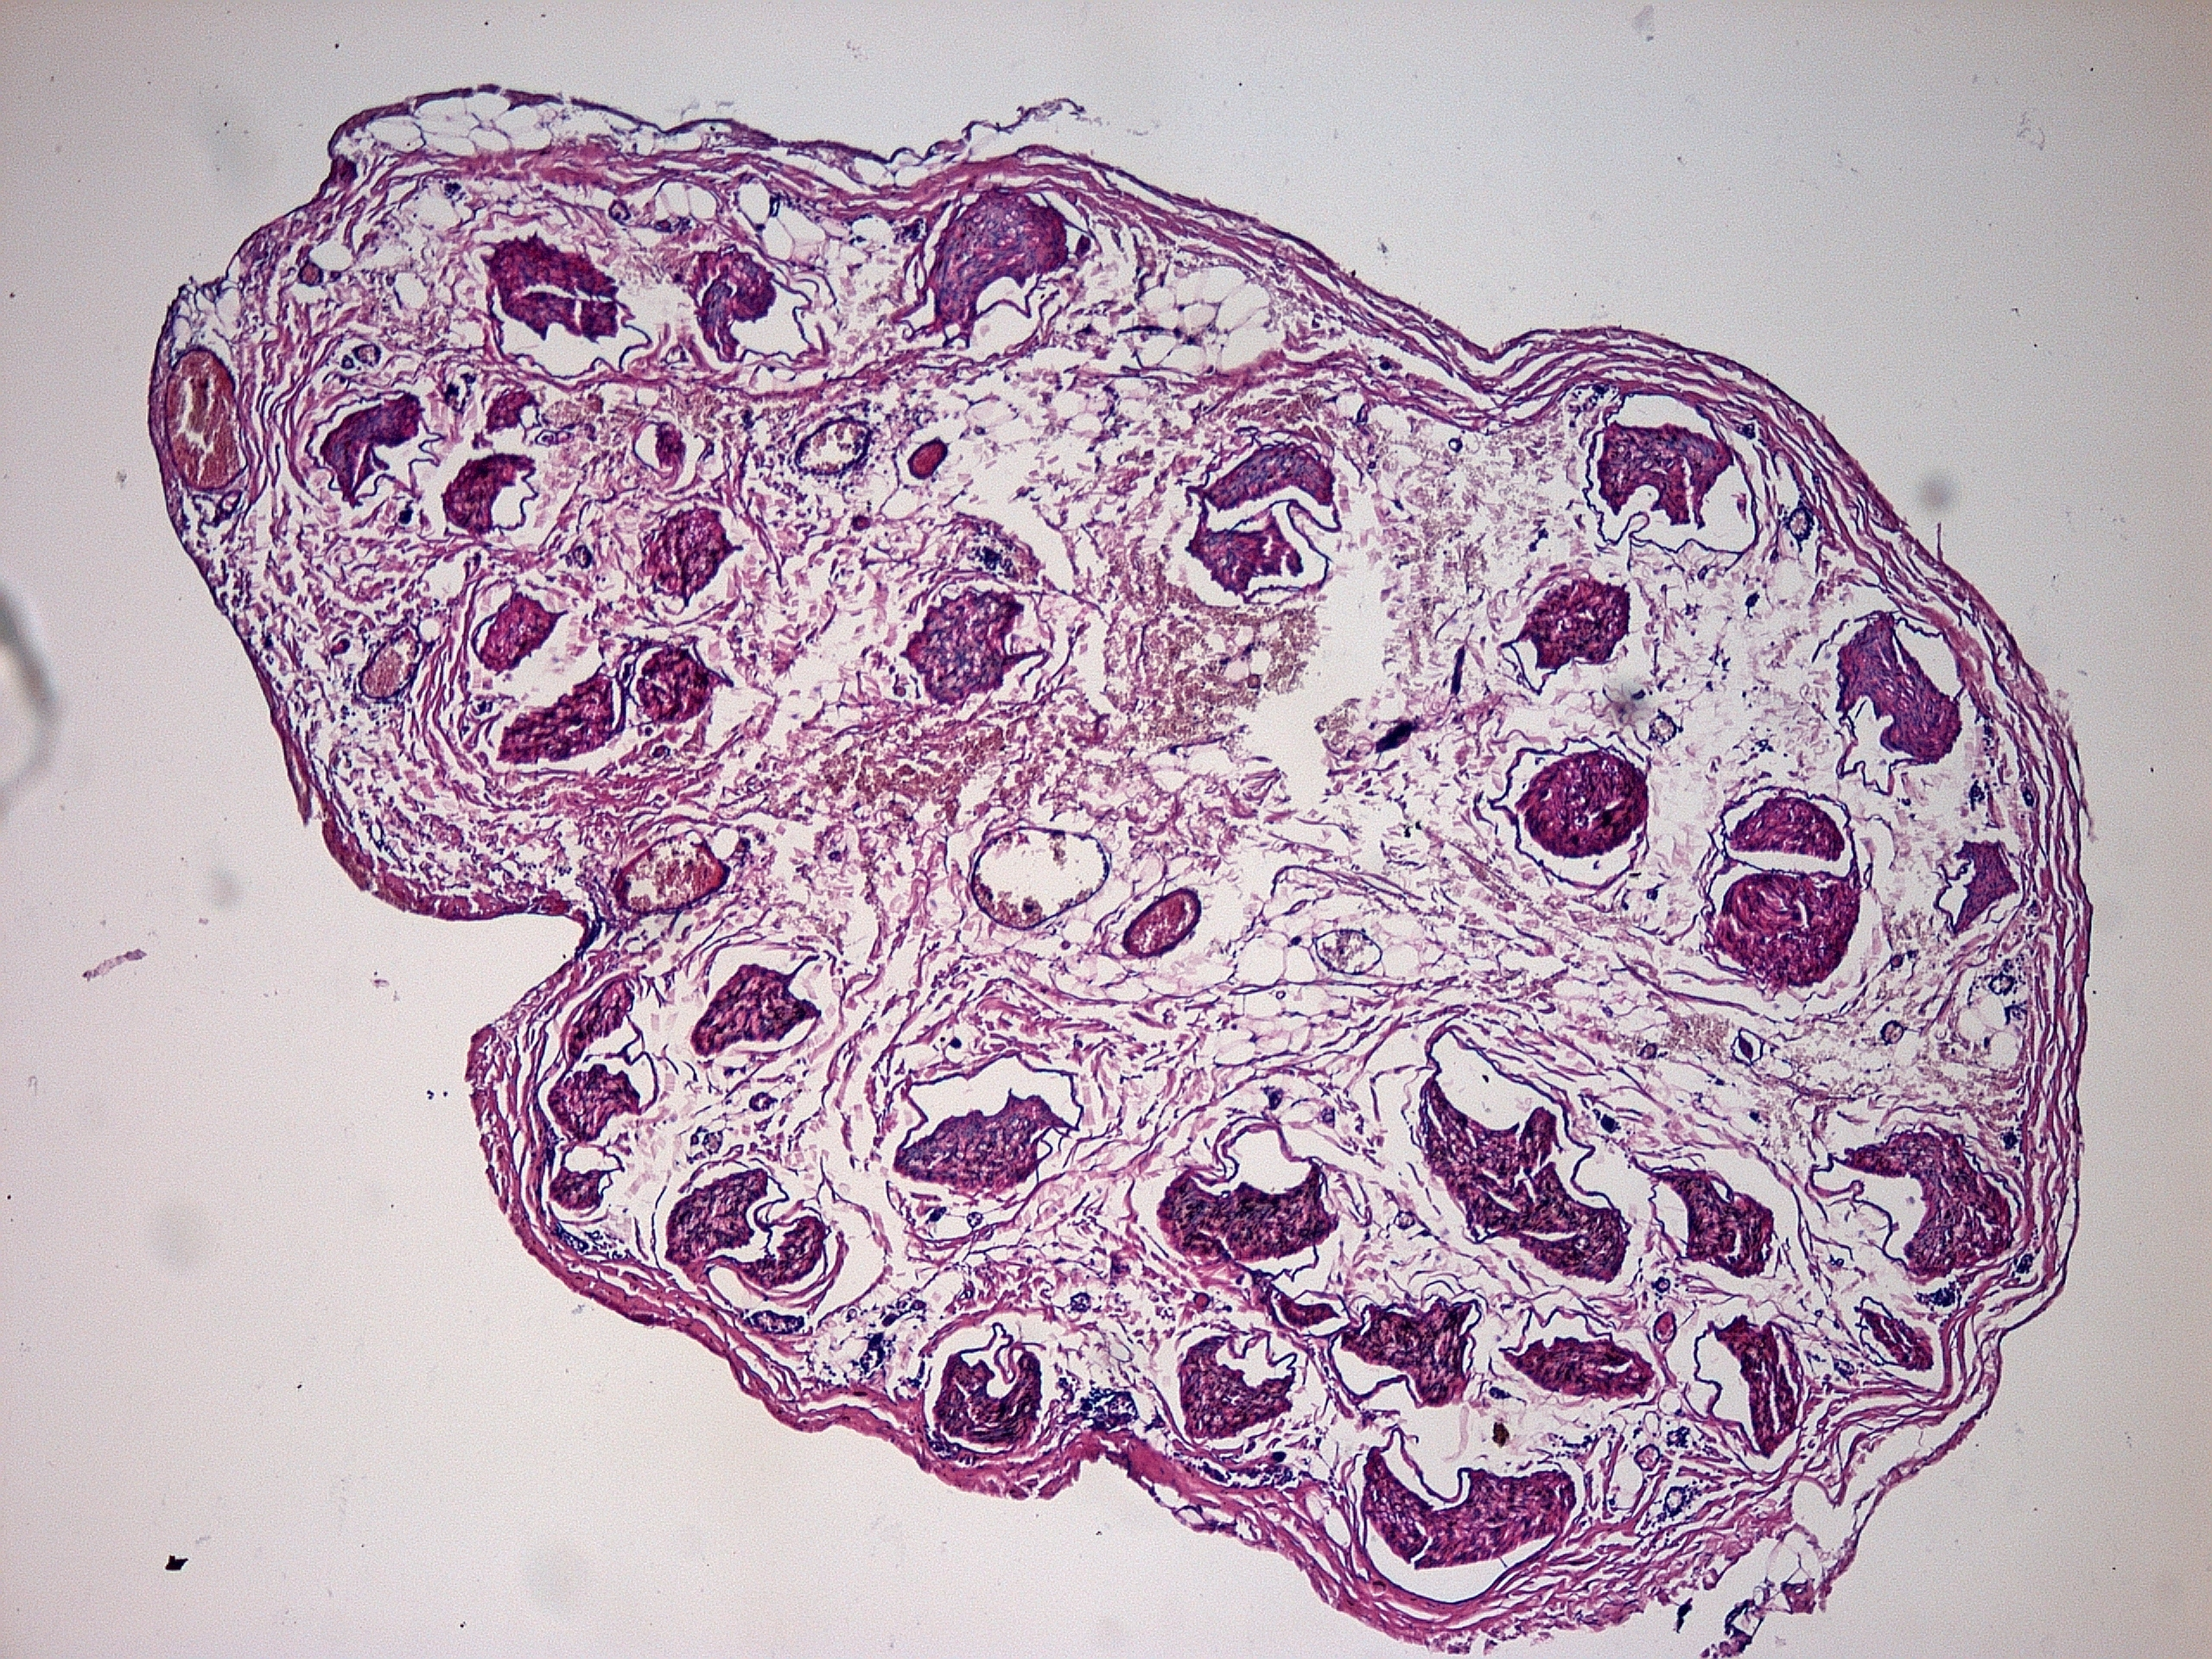

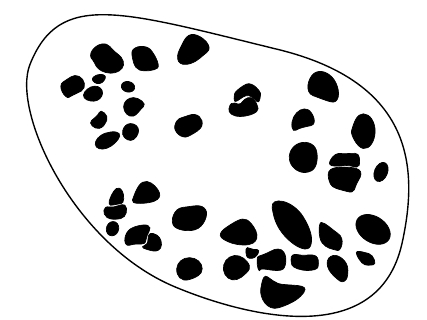

In [13]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [34]:
np.asarray(load_img(target_img_paths[9]))

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

## Prepare `Sequence` class to load & vectorize batches of data

In [14]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


## Prepare U-Net Xception-style model

In [25]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Set aside a validation split

In [26]:
import random

# Split our img paths into a training and a validation set
val_samples = 6
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

In [27]:
print(len(input_img_paths))
print(len(train_gen))
print(len(val_gen))

48
21
3


In [28]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 1
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

2021-11-17 18:39:33.868923: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at sparse_xent_op.cc:90 : Invalid argument: Received a label value of 255 which is outside the valid range of [0, 3).  Label values: 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 2

InvalidArgumentError:  Received a label value of 255 which is outside the valid range of [0, 3).  Label values: 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 223 164 164 164 164 164 164 164 164 196 222 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 253 254 254 254 254 222 88 255 255 255 88 88 164 222 222 244 254 254 254 254 254 222 222 223 164 88 88 255 255 255 67 164 222 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 255 255 88 180 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 233 195 88 255 255 88 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 67 255 88 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 87 255 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 88 255 255 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 255 255 164 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 88 45 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 180 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 255 255 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 255 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 23 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 88 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 181 255 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 66 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 0 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 161 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 0 112 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 47 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 6 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 0 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 146 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 128 253 254 254 254 254 254 254 254 254 254 29 255 255 71 254 254 254 254 254 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 51 255 255 255 255 244 254 254 254 177 255 255 255 255 255 255 4 254 254 254 254 254 254 254 254 254 243 5 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 250 254 253 254 254 254 254 254 254 254 134 255 255 255 255 255 11 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 254 254 192 255 255 255 255 255 255 255 255 66 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 0 255 255 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 255 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 250 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 254 254 164 0 255 255 255 255 255 255 255 255 250 254 254 254 254 250 7 255 255 255 255 255 255 255 255 255 255 255 255 143 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 253 254 254 255 255 255 255 255 255 255 255 255 10 254 254 253 254 11 255 255 255 255 255 255 255 255 255 255 255 255 255 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 222 255 0 255 255 255 255 134 254 254 254 72 255 0 255 255 255 255 255 255 255 254 254 254 254 67 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 250 255 255 255 255 255 255 254 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 254 254 5 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 250 254 254 254 254 254 193 255 255 255 255 255 255 255 255 140 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 9 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 180 254 253 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 169 255 255 29 254 254 254 254 29 255 255 255 255 255 255 255 57 254 254 254 254 254 233 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 180 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 11 255 255 13 255 255 255 255 71 254 254 254 254 243 11 15 67 222 210 67 187 254 254 254 254 254 254 51 255 255 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 9 46 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 254 254 254 254 192 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 255 255 255 255 67 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 233 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 17 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 250 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 0 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 177 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 255 255 255 90 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 12 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 30 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 46 23 105 254 254 254 254 233 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 112 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 15 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 29 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 117 255 255 255 255 255 255 255 67 254 254 254 254 254 254 254 254 254 254 254 254 250 143 72 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 11 255 255 255 17 144 254 254 254 254 254 254 254 254 253 254 254 254 243 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 29 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 193 255 255 255 255 255 134 254 254 254 254 254 254 254 254 112 255 255 255 0 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 45 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 117 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 7 255 255 255 255 0 255 255 254 254 254 254 254 254 254 47 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 233 254 254 254 254 254 254 254 254 254 254 192 255 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 109 254 254 254 254 254 254 254 254 254 254 255 255 255 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 4 255 255 255 9 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 253 206 255 255 255 255 255 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 233 255 255 255 255 134 254 254 254 254 254 254 254 5 0 255 255 90 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 87 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 254 254 254 254 254 254 254 254 255 255 255 255 255 254 66 30 243 254 254 254 26 255 0 255 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 11 253 254 5 255 255 255 255 255 255 255 255 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 254 254 250 255 255 255 255 255 5 255 255 0 255 254 254 255 255 255 255 255 255 5 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 250 254 250 255 255 255 255 255 255 255 255 255 255 255 255 255 250 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 222 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 254 254 254 254 254 254 254 5 255 255 255 64 255 255 255 255 255 254 243 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 255 255 255 255 255 5 254 254 4 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 243 255 255 255 3 0 255 255 255 255 253 195 255 255 255 255 255 255 255 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 157 7 255 209 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 72 253 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 255 255 128 255 0 255 255 255 255 233 143 255 255 255 255 255 255 9 254 254 254 254 243 7 255 255 9 254 254 254 254 254 254 254 254 9 255 255 255 255 117 254 254 254 254 254 254 254 254 29 7 15 43 143 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 67 209 255 255 255 255 255 255 47 254 254 254 254 255 0 255 255 255 250 254 254 254 254 254 254 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 15 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 22 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 254 254 254 254 254 254 254 11 255 0 255 255 255 46 254 255 255 255 255 255 255 233 254 254 254 117 255 255 255 255 255 255 254 254 254 253 254 72 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 243 255 255 255 255 255 255 255 255 255 255 255 255 207 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 112 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 66 254 254 254 254 254 254 254 254 253 254 254 255 255 255 255 255 209 254 192 255 0 255 255 173 254 254 254 254 255 255 255 255 255 255 255 254 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 11 255 255 255 255 254 254 254 192 255 255 192 254 254 254 254 254 0 255 0 255 255 255 255 254 254 254 254 254 255 255 0 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 255 255 0 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 250 254 254 254 254 254 254 254 254 254 254 254 72 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 254 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 255 255 255 255 255 255 0 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 11 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 109 254 254 254 254 254 254 254 254 254 254 254 254 172 15 157 254 254 254 254 254 254 254 254 254 254 254 254 255 255 0 255 255 255 255 253 254 254 254 254 255 255 255 255 255 255 255 0 15 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 0 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 254 254 254 254 254 255 255 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 117 255 255 255 255 255 255 255 192 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 66 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 233 254 254 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 7 255 255 255 140 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 255 255 255 255 255 255 255 255 255 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 233 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 46 255 255 255 67 254 254 254 254 254 254 255 255 255 255 255 255 255 29 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 209 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 157 11 255 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 164 254 254 254 254 254 254 254 254 254 254 254 254 254 147 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 255 255 255 255 255 255 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 143 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 255 255 0 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 28 255 255 255 255 255 255 255 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 255 255 255 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 11 255 255 255 255 255 255 255 0 30 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 72 255 255 255 233 254 253 254 254 254 254 254 254 254 254 254 254 254 254 67 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 84 12 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 254 254 254 251 255 255 23 243 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 255 255 255 255 11 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 11 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 255 255 255 9 254 254 254 254 254 254 254 254 254 254 254 254 254 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 250 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 72 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 13 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 10 255 255 255 255 255 255 10 253 254 254 254 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 222 255 255 255 255 255 255 255 47 254 254 254 254 254 254 254 254 254 254 254 253 254 233 255 255 255 255 255 255 255 255 255 255 255 11 254 254 192 255 0 255 255 255 255 255 255 254 254 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 22 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 255 255 255 255 255 255 209 253 254 254 254 254 243 255 255 112 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 0 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 255 255 255 255 255 255 255 5 254 254 243 255 255 0 255 255 255 255 255 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 255 62 254 254 254 254 254 255 255 0 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 62 23 23 62 250 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 9 255 255 255 255 255 255 255 254 254 254 5 255 255 255 255 255 255 255 0 0 150 254 254 254 254 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 15 255 255 255 255 255 255 255 254 254 254 254 72 255 255 255 255 255 192 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 233 254 254 254 255 255 255 255 255 255 255 255 255 255 209 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 7 254 254 254 254 255 255 255 255 255 255 10 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 255 255 255 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 23 84 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 250 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 9 255 255 255 255 255 255 255 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 29 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 6 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 255 255 255 255 255 255 255 5 223 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 172 254 254 254 254 254 163 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 15 255 255 255 7 255 209 254 254 254 195 62 255 150 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 222 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 209 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 67 254 254 254 254 29 0 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 112 7 255 255 255 255 255 255 47 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 57 255 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 251 255 255 255 255 255 255 243 254 254 254 254 254 7 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 47 255 255 255 255 23 255 255 255 255 255 255 255 255 255 255 255 0 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 254 254 254 254 254 254 254 250 29 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 7 134 7 243 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 255 17 192 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 9 254 255 255 7 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 67 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 255 255 255 11 254 6 255 255 255 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 233 254 255 255 255 0 255 254 254 254 254 253 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 57 43 15 255 255 255 255 255 255 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 105 255 255 255 255 255 255 255 255 255 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 255 255 255 255 255 255 255 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 158 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 255 255 255 255 254 254 254 253 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 193 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 255 255 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 47 255 255 255 255 255 255 255 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 253 254 84 9 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 11 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 255 255 255 255 255 255 255 255 255 255 47 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 7 139 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 117 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 44 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 113 255 23 30 255 57 222 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 243 253 254 254 254 254 254 254 254 255 255 255 255 255 255 255 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 250 254 254 254 254 254 254 254 28 255 255 255 255 255 67 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 28 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 255 255 51 254 254 254 254 254 254 254 254 255 255 255 255 255 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 255 7 15 250 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 150 43 46 254 254 254 254 254 10 255 255 255 255 255 255 255 255 255 255 255 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 243 254 254 254 254 254 254 254 6 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 62 255 255 255 255 255 254 254 254 254 95 255 255 255 255 255 255 255 255 255 255 0 255 222 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 253 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 10 255 255 90 254 254 254 254 254 72 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 253 254 254 254 254 254 253 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 6 255 255 255 0 117 254 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 250 255 255 255 255 255 255 255 255 255 255 255 255 90 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 110 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 255 255 0 255 254 254 254 192 255 255 255 255 255 255 255 9 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 22 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 255 0 255 255 254 254 254 7 255 255 255 255 255 255 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 15 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 254 254 254 254 254 254 254 254 254 254 254 254 254 11 255 255 255 255 255 255 90 254 254 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 12 254 254 254 15 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 15 254 254 0 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 255 255 255 255 255 177 254 254 254 29 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 233 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 13 254 254 255 255 0 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 67 7 255 255 67 254 254 254 254 254 254 254 254 254 254 254 254 254 223 255 255 255 255 255 255 255 255 255 255 255 0 255 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 250 253 253 222 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 255 255 255 255 255 11 254 254 254 254 30 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 23 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 255 254 254 254 254 243 105 29 94 254 254 254 254 254 254 254 254 254 254 206 255 255 255 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 177 254 254 254 254 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 222 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 7 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 105 255 255 255 255 255 255 255 255 255 254 254 254 254 250 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 253 254 254 254 254 254 254 254 254 254 254 233 9 255 7 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 255 0 255 255 255 255 255 255 12 253 253 254 254 254 250 255 255 255 255 255 255 255 255 95 254 254 254 172 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 254 253 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 7 255 255 255 255 255 255 255 254 254 254 254 255 0 255 255 255 255 0 255 254 254 254 254 254 254 254 254 254 254 254 254 209 253 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 118 255 255 255 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 9 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 51 254 254 254 254 254 254 254 254 254 254 28 255 255 255 0 233 254 254 254 11 255 255 255 255 255 255 255 255 222 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 45 253 254 254 254 254 254 254 254 254 254 157 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 7 11 250 254 253 254 254 255 0 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 23 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 253 254 254 254 254 254 254 254 254 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 128 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 233 254 254 254 254 254 254 254 254 255 255 255 255 255 254 254 254 254 254 254 222 250 254 254 254 254 254 254 254 254 57 255 255 255 255 255 255 255 255 255 255 33 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 29 254 253 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 250 254 254 254 254 254 254 210 255 255 255 255 134 254 254 254 134 255 255 255 255 250 254 254 254 254 254 254 254 67 255 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 62 24 255 255 255 255 255 255 11 157 254 254 254 254 254 254 254 254 254 254 254 253 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 165 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 209 77 233 254 254 105 255 255 255 255 255 255 255 254 254 254 254 254 254 254 150 0 255 255 255 255 255 255 255 255 255 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 164 254 254 254 254 254 254 254 254 254 254 254 13 255 255 255 255 255 255 255 255 243 254 254 254 254 254 254 254 6 255 255 255 255 255 255 255 255 7 254 134 255 255 255 255 255 13 254 254 254 254 254 254 254 254 254 254 13 255 255 255 255 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 7 255 255 5 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 22 254 254 254 254 254 254 254 254 254 254 250 255 255 255 255 255 0 255 255 255 7 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 250 254 255 255 0 255 255 255 255 11 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 34 255 255 255 255 95 255 255 255 255 255 141 254 254 254 254 254 254 254 254 254 254 254 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 253 7 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 250 254 51 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 243 255 255 255 255 255 255 255 250 29 255 15 243 254 254 254 254 254 254 254 254 254 254 254 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 23 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 250 84 30 255 47 254 254 254 255 255 255 255 255 255 255 255 255 67 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 7 0 255 255 255 255 255 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 233 254 254 254 254 254 254 180 255 255 255 255 255 255 255 255 255 255 255 62 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 25 255 255 255 255 255 255 255 255 255 255 255 255 254 254 255 255 255 255 255 255 255 255 255 255 26 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 222 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 13 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 255 255 255 134 254 140 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 255 255 255 255 255 255 255 0 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 5 254 254 7 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 255 254 254 254 254 254 150 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 128 254 254 254 254 254 254 254 254 51 255 255 255 255 255 255 255 255 51 254 254 254 172 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 164 254 254 254 254 254 112 255 255 255 255 255 255 192 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 57 254 254 254 254 254 254 254 254 254 117 255 255 255 255 255 5 209 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 87 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 66 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 113 254 254 254 254 254 254 254 253 254 254 209 255 62 143 254 254 254 254 254 254 254 254 51 255 255 255 255 255 255 255 255 255 17 254 254 254 254 254 254 254 254 254 254 254 195 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 19 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 0 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 253 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 255 255 255 255 255 0 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 5 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 51 255 255 255 255 255 255 255 255 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 57 150 254 254 254 254 254 254 254 254 254 254 254 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 68 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 255 255 255 255 12 105 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 255 18 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 243 254 254 254 254 253 254 254 254 254 254 254 254 254 195 67 255 255 255 254 254 254 254 254 222 255 255 255 255 255 255 255 255 255 15 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 254 254 253 254 28 255 255 255 255 255 255 255 255 255 255 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 32 255 0 255 255 255 255 255 255 233 254 253 72 255 255 255 255 255 255 255 255 255 255 255 0 222 254 254 254 254 254 254 254 254 254 254 254 250 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 143 254 233 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 29 255 11 251 254 254 254 254 254 254 254 254 254 254 254 254 255 255 0 255 255 255 255 255 255 150 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 253 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 255 0 255 255 255 255 255 255 255 233 84 255 255 255 255 255 255 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 255 11 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 254 244 0 255 0 255 255 255 255 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 255 250 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 253 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 223 255 255 0 255 255 255 255 255 255 255 255 29 254 253 254 254 254 254 253 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 45 254 254 254 254 254 254 254 254 254 254 254 254 47 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 253 254 51 255 0 255 255 255 255 255 177 254 254 254 254 134 255 255 255 255 255 255 255 11 243 254 254 253 254 254 253 254 254 210 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 196 254 254 254 254 254 254 254 254 254 254 254 255 255 0 255 255 255 222 254 254 254 253 254 254 254 254 254 243 222 253 254 254 254 254 254 254 254 254 254 254 164 87 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 128 77 95 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 87 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 250 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 222 254 254 254 254 254 254 254 117 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 66 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 89 128 254 254 254 254 254 254 254 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 255 232 254 254 254 254 254 4 255 255 255 255 255 30 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 255 164 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 45 243 254 254 254 250 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 45 254 254 254 254 15 15 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 255 66 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 255 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 44 255 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 255 23 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 67 255 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 255 255 146 243 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 109 255 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 146 67 255 255 255 88 164 164 222 222 222 222 164 165 88 255 255 255 88 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 221 222 222 222 222 222 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 222 222 164 164 164 164 164 164 222 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 23 255 255 255 88 164 164 222 222 222 222 222 222 222 222 163 146 88 255 255 255 23 88 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 255 255 108 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 88 255 255 88 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 255 110 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 88 255 255 164 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 45 209 254 253 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 88 255 44 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 45 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 255 255 43 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 164 23 255 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 44 254 254 254 254 254 254 233 5 255 51 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 255 177 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 195 45 255 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 222 254 254 254 254 253 254 254 255 255 255 255 206 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 255 255 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 180 255 23 250 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 88 254 253 254 254 254 254 254 254 51 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 95 0 255 255 255 255 255 255 255 255 206 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 164 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 4 255 0 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 233 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 222 255 255 255 255 255 255 29 254 254 254 254 254 254 254 254 13 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 255 180 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 11 255 255 255 255 255 255 255 254 254 254 254 254 254 254 193 255 255 255 255 255 255 255 255 255 255 255 255 0 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 255 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 233 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 253 180 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 250 254 254 254 254 254 254 254 254 254 254 253 254 255 255 255 255 255 255 255 255 47 254 254 254 254 254 254 17 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 0 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 129 254 254 254 254 254 254 254 254 254 254 254 254 254 11 255 255 255 255 255 255 0 255 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 243 255 180 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 250 134 62 233 254 254 254 112 255 255 255 255 255 255 255 255 177 254 254 254 254 254 254 10 255 0 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 255 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 243 254 254 254 254 254 254 250 255 255 255 255 72 254 254 254 255 255 255 255 255 255 255 0 10 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 255 222 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 254 254 254 254 254 254 254 255 255 255 255 255 255 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 253 128 23 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 23 254 254 254 254 254 254 254 254 255 255 255 255 255 255 206 254 254 66 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 250 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 195 255 255 255 255 255 255 255 254 254 254 255 255 255 255 255 255 129 243 254 254 254 254 254 254 254 254 254 206 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 254 254 254 7 255 255 255 255 192 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 105 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 43 255 255 255 255 255 255 255 254 254 254 254 6 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 44 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 128 254 254 254 254 254 254 254 254 30 255 255 255 255 255 255 255 254 254 254 254 254 255 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 222 255 0 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 254 254 254 254 254 254 254 254 254 253 255 255 255 255 255 178 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 109 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 7 72 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 23 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 254 254 254 254 254 254 254 254 254 254 254 254 164 183 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 117 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 253 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 57 255 62 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 253 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 254 254 254 222 7 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 255 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 77 255 255 255 255 255 255 255 254 254 254 255 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 206 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 46 254 254 67 255 255 255 84 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 72 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 250 255 255 255 255 255 255 254 254 254 47 255 255 0 9 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 253 254 254 10 255 255 255 255 233 254 254 254 209 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 255 255 255 255 255 255 255 255 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 255 7 112 254 254 254 253 254 254 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 255 255 255 255 255 255 255 57 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 143 95 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 62 255 255 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 28 255 4 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 255 255 255 30 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 254 254 254 254 254 254 254 192 255 255 255 222 254 254 254 254 254 254 254 254 15 255 30 57 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 254 254 192 255 255 255 255 11 254 254 254 254 254 254 254 6 255 255 255 255 11 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 177 254 253 254 254 254 254 233 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 157 7 15 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 254 254 254 254 192 255 255 255 255 255 254 254 254 254 254 254 254 43 255 255 255 255 255 255 67 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 9 222 254 254 222 143 209 254 254 254 254 254 13 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 84 255 255 255 255 11 254 254 254 254 254 254 254 17 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 84 30 255 255 255 255 254 254 254 254 254 254 7 255 255 0 255 255 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 250 255 255 255 255 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 254 254 254 254 254 222 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 0 255 255 255 112 254 254 254 254 51 255 255 255 255 255 255 9 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 250 254 254 254 254 255 255 255 192 254 254 254 254 254 254 254 254 255 255 255 255 255 255 7 254 254 254 223 255 255 255 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 128 254 254 254 254 233 255 255 254 254 254 254 77 7 254 254 254 7 255 255 255 255 255 222 254 254 117 255 255 255 255 255 7 243 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 255 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 5 255 255 255 254 254 250 255 255 255 255 7 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 192 255 255 255 255 254 254 254 254 46 255 84 254 254 254 195 255 255 255 255 255 255 255 255 254 254 254 254 243 11 255 255 255 255 177 254 254 254 254 254 255 255 255 255 255 255 255 255 255 9 254 254 254 222 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 254 254 254 254 254 254 254 254 254 255 255 255 255 105 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 157 254 254 254 255 255 255 255 255 255 255 192 254 254 254 254 255 255 255 255 255 255 255 255 255 222 254 254 254 222 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 254 254 254 254 254 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 67 254 254 233 255 255 255 255 255 255 255 23 254 254 254 254 255 0 255 255 255 255 255 255 255 254 253 254 254 222 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 254 254 254 254 254 254 254 62 255 255 0 255 254 254 254 254 254 254 254 254 254 254 254 164 255 255 255 255 255 255 255 255 57 254 254 11 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 0 255 255 117 254 254 254 254 222 255 255 255 255 255 255 255 255 255 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 57 255 255 0 255 254 254 254 254 254 254 254 254 254 254 254 223 255 255 255 255 255 255 255 255 57 254 254 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 6 254 254 254 254 254 254 255 255 255 255 255 255 0 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 95 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 57 254 254 0 255 255 255 255 255 255 255 134 254 254 254 254 112 255 0 255 255 255 112 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 66 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 254 254 254 254 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 157 254 254 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 57 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 254 254 254 5 255 255 255 253 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 243 254 254 7 255 255 255 255 255 255 7 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 253 254 254 254 254 254 254 254 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 51 255 255 255 255 255 255 255 254 254 254 112 255 255 255 255 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 253 254 112 255 255 255 255 255 51 254 254 254 254 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 62 255 255 243 254 254 254 254 254 255 255 255 255 255 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 0 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 7 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 222 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 133 255 255 255 250 254 255 255 0 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 15 255 255 255 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 3 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 161 5 255 0 255 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 12 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 8 255 13 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 255 255 255 255 0 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 253 5 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 90 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 254 254 164 210 254 254 254 254 253 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 47 254 254 253 254 7 255 255 255 133 254 253 254 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 7 255 255 140 254 254 254 254 254 253 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 253 254 254 5 255 255 255 255 255 72 254 254 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 8 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 206 255 255 255 255 0 51 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 255 255 255 255 255 255 255 177 254 5 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 254 254 254 254 250 255 255 255 255 255 255 255 7 254 254 254 254 253 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 255 255 255 255 255 255 255 29 254 254 209 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 128 254 254 254 254 254 254 254 254 254 254 0 255 255 255 255 255 255 255 255 254 254 254 255 255 255 255 255 255 0 13 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 251 254 253 254 254 254 254 254 254 254 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 254 254 254 5 255 0 255 255 255 255 255 255 255 254 254 254 254 254 254 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 11 0 255 255 255 255 255 255 255 254 254 254 255 255 255 255 255 255 255 209 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 9 255 255 255 7 222 254 254 254 254 254 254 254 206 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 5 255 255 255 255 255 255 255 255 255 255 254 254 254 253 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 13 254 254 254 255 255 255 255 0 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 112 255 255 255 255 255 255 255 177 254 254 254 254 254 254 254 254 250 210 62 255 255 255 255 255 255 0 255 255 255 255 5 254 254 192 255 255 255 255 255 255 255 255 255 255 255 254 253 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 254 254 254 254 5 255 255 255 255 255 66 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 90 255 255 255 255 255 255 255 255 255 77 254 254 254 254 254 253 254 254 254 253 254 254 254 7 255 255 255 255 255 255 255 255 254 254 254 255 255 255 255 255 255 255 255 255 255 255 29 254 253 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 254 254 254 254 254 254 254 254 253 254 29 255 255 255 255 255 11 254 254 254 254 254 7 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 0 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 11 255 255 255 255 255 11 254 254 254 13 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 11 255 0 255 157 254 254 254 253 254 254 254 47 255 255 72 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 0 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 62 255 255 209 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 250 254 254 254 254 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 253 222 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 0 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 47 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 32 255 255 255 255 255 255 255 255 255 255 51 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 255 255 255 255 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 51 255 255 255 255 255 255 255 47 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 192 254 254 254 254 254 254 254 254 254 254 254 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 222 222 254 254 254 254 254 254 254 254 157 6 17 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 255 255 255 0 7 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 222 62 255 255 255 255 255 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 7 255 255 157 243 5 255 255 233 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 11 255 255 255 255 255 15 31 255 255 255 255 255 255 255 255 255 255 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 72 255 255 255 255 255 255 15 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 253 164 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 11 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 180 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 255 255 255 255 255 255 255 250 254 254 254 254 254 254 222 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 255 255 255 255 255 255 255 255 255 255 255 150 254 254 254 254 254 254 233 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 250 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 3 255 255 255 0 255 255 255 255 255 255 255 56 254 254 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 6 255 255 29 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 178 255 255 255 255 255 255 255 255 255 255 255 255 255 5 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 13 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 89 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 45 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 254 253 254 254 254 254 143 143 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 105 5 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 15 255 0 255 255 255 255 255 95 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 255 255 255 255 255 11 254 254 254 254 7 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 243 10 255 255 255 255 255 255 13 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 13 255 255 255 255 254 254 254 254 254 254 254 254 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 255 255 254 254 254 4 255 255 255 255 7 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 165 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 67 157 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 254 254 222 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 12 255 10 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 195 254 9 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 11 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 222 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 157 254 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 95 255 255 255 255 255 255 255 255 72 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 222 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 253 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 233 254 255 0 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 13 255 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 44 243 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 0 255 254 254 7 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 90 15 255 255 255 255 255 11 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 87 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 253 254 250 255 255 255 255 255 5 254 254 206 255 0 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 26 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 11 255 255 255 255 255 255 255 255 255 255 255 0 255 11 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 254 254 254 254 0 255 255 255 255 158 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 0 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 222 254 254 254 254 254 250 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 0 255 255 255 222 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 56 57 244 254 254 254 254 254 254 254 254 254 253 250 91 150 0 255 255 255 255 255 254 254 254 254 254 254 254 254 254 253 128 255 255 255 255 255 255 255 255 255 255 255 255 28 254 254 254 254 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 255 0 255 7 254 255 255 255 255 254 254 254 254 254 254 254 254 254 254 57 255 255 255 255 255 255 255 255 255 255 255 255 232 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 5 233 255 255 13 254 253 254 254 254 254 254 254 254 253 95 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 146 254 254 254 254 254 254 254 254 254 254 254 222 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 13 255 255 255 255 255 255 253 7 255 254 254 254 254 254 254 254 254 254 254 254 243 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 254 254 254 254 254 254 254 254 253 254 254 254 253 254 254 254 94 255 255 255 255 255 0 255 11 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 67 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 209 254 254 254 254 254 254 254 254 254 255 255 255 255 255 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 28 255 255 255 255 255 255 255 255 0 255 254 254 254 254 222 0 255 255 255 255 255 255 255 255 255 255 255 255 192 254 254 11 255 0 29 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 44 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 253 254 254 254 254 254 254 254 254 255 255 255 255 255 233 254 254 254 254 244 195 254 254 254 254 254 254 254 206 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 0 233 254 254 254 254 95 255 0 255 255 255 255 255 255 255 255 255 50 254 254 254 255 255 255 255 255 51 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 233 254 254 254 253 254 254 254 254 255 255 255 255 255 254 254 254 13 0 0 255 7 254 254 254 254 254 254 6 255 255 255 255 255 255 255 255 255 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 7 255 255 255 255 255 255 5 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 50 250 254 253 254 72 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 255 255 255 255 7 253 47 255 255 255 255 255 255 51 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 0 255 255 255 6 254 254 254 254 254 254 253 254 254 222 11 255 255 255 112 254 254 254 254 254 254 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 23 254 254 254 254 254 254 254 254 15 255 255 206 11 255 255 255 255 255 255 255 255 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 222 143 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 255 255 255 255 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 254 254 254 254 254 254 254 254 254 244 249 95 255 255 255 255 255 255 255 255 255 12 254 254 254 254 13 255 255 255 255 255 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 255 0 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 192 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 255 0 255 255 255 255 255 255 255 90 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 222 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 195 250 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 222 254 254 254 253 29 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 222 254 254 254 254 254 254 254 254 254 146 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 255 0 255 255 255 255 255 255 255 255 255 255 254 254 253 254 254 254 5 255 255 255 255 255 255 11 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 157 62 58 56 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 250 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 13 254 254 254 254 254 254 254 250 4 255 255 255 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 255 255 255 255 255 255 255 255 255 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 46 255 255 255 255 255 255 29 254 254 254 254 254 254 254 254 254 253 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 233 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 5 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 13 30 32 254 253 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 254 222 221 254 254 254 254 112 255 255 255 7 250 254 254 254 254 254 254 254 254 254 254 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 51 255 255 255 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 255 0 255 255 7 43 254 254 254 254 254 254 254 254 254 254 233 255 255 0 255 255 255 255 255 255 255 255 7 253 254 254 254 254 254 254 140 255 255 255 255 117 254 254 254 7 23 118 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 13 255 255 255 255 0 255 157 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 250 255 255 255 255 255 255 255 6 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 250 11 255 0 255 255 255 255 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 67 128 254 254 254 254 254 254 47 255 255 0 26 250 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 255 255 255 255 51 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 206 255 255 255 255 255 255 255 255 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 233 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 7 254 254 254 243 0 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 0 6 254 254 254 254 254 254 254 13 255 255 255 255 255 255 255 255 255 255 255 206 254 254 254 255 255 255 0 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 195 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 243 7 255 255 255 255 255 255 255 255 4 254 254 254 67 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 95 255 255 255 255 255 255 255 255 255 255 0 255 254 254 254 254 254 254 254 254 254 254 112 255 255 255 255 255 255 255 254 254 254 254 15 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 57 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 29 255 255 255 7 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 62 255 255 255 255 255 255 255 255 255 255 255 244 254 254 254 254 254 254 254 254 254 254 253 254 254 233 32 12 254 254 254 254 254 254 57 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 179 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 150 255 255 255 255 255 255 255 255 255 255 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 255 255 255 255 255 255 255 255 255 255 28 254 254 254 254 254 254 254 254 254 254 254 254 243 255 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 165 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 7 222 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 0 255 255 255 0 255 29 254 254 254 254 254 254 254 254 254 254 254 254 196 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 67 250 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 7 209 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 112 255 255 255 255 7 250 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 143 128 243 254 254 254 254 254 143 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 250 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 233 254 254 117 255 255 255 255 13 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 5 255 255 255 255 255 47 254 254 255 255 255 255 255 255 255 255 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 5 255 255 177 254 254 254 254 254 254 254 254 254 254 254 254 254 51 255 255 255 255 255 255 255 254 7 255 255 255 255 255 0 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 22 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 254 255 255 255 255 255 255 255 255 255 255 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 9 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 67 255 255 255 255 255 255 255 255 172 255 255 255 255 255 255 255 255 255 255 15 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 233 255 255 255 255 255 255 255 222 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 11 11 255 255 255 255 255 255 255 255 255 255 15 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 254 254 254 254 254 254 254 254 254 254 57 255 255 255 255 255 255 255 11 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 157 255 255 255 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 253 9 255 255 255 255 255 255 255 254 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 255 250 254 254 254 254 254 254 254 67 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 219 255 255 255 255 255 255 51 222 255 255 255 255 255 255 255 255 255 255 11 254 254 254 254 254 254 254 254 254 254 254 254 254 233 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 22 250 254 254 254 254 254 254 177 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 10 255 255 255 255 11 253 254 255 255 0 255 255 255 255 255 255 47 254 254 254 254 254 254 253 254 254 254 254 254 254 23 67 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 243 254 254 254 254 254 254 255 255 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 253 254 254 222 161 161 254 254 254 254 67 255 255 255 255 15 90 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 45 254 254 254 254 254 7 255 255 255 0 255 255 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 128 62 134 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 109 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 255 253 254 254 254 117 255 255 255 255 255 156 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 255 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 45 253 254 254 5 255 255 11 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 23 23 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 255 222 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 45 45 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 181 255 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 255 45 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 250 45 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 255 255 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 67 255 45 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 89 255 255 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 209 88 255 255 255 88 164 164 223 222 222 222 223 164 164 88 255 255 255 88 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 253 254 254 254 254 254 222 222 164 164 163 222 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at tmp/ipykernel_48165/3906512991.py:12) ]] [Op:__inference_train_function_14201]

Function call stack:
train_function


54 254 254 254 254 254 254 254 254 254 254 254 254 164 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 44 243 254 254 254 254 254 254 254 254 254 254 254 254 7 255 255 255 255 0 255 254 254 7 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 7 255 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 90 15 255 255 255 255 255 11 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 0 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 87 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 254 254 254 254 254 254 254 254 254 254 253 254 250 255 255 255 255 255 5 254 254 206 255 0 255 255 255 255 254 254 254 

## Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.